Most of the dependencies are handled in the other modules, but we import a few general ones here for use below and future expansion purposes.
Notice that we are also modifying the matplotlib settings to work with LaTeX math-mode syntax.

In [1]:
import stim
from matplotlib import pyplot as plt
from jupyter_plotter import plot_jupyter_figure
import pymatching # Decoding
from circuit_generators import *
from sampling_functions import *
import numpy as np

# Also define the number of worker nodes here
n_worker_nodes = 8

In [2]:
n_samples = 6000000
decoders = ['pymatching']
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_z",
  distance=4,
  rounds=1,
  before_round_data_depolarization = 0.01,
  after_reset_flip_probability = 0.01,
  after_clifford_depolarization = 0.01,
  before_measure_flip_probability = 0.01
)
m_sampler = test_circuit.compile_sampler(seed=12345)
d_sampler = test_circuit.compile_detector_sampler(seed=12345)
converter = test_circuit.compile_m2d_converter()

measurements = m_sampler.sample(n_samples, bit_packed=False)
det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
measurements = measurements.astype(np.int16)
det_evts = det_evts.astype(np.int16)
flips = flips.astype(np.int16)
print(test_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(1, 3) 10
QUBIT_COORDS(2, 2) 11
QUBIT_COORDS(3, 3) 12
QUBIT_COORDS(4, 2) 13
QUBIT_COORDS(5, 3) 14
QUBIT_COORDS(6, 2) 15
QUBIT_COORDS(7, 3) 16
QUBIT_COORDS(0, 4) 18
QUBIT_COORDS(1, 5) 19
QUBIT_COORDS(2, 4) 20
QUBIT_COORDS(3, 5) 21
QUBIT_COORDS(4, 4) 22
QUBIT_COORDS(5, 5) 23
QUBIT_COORDS(6, 4) 24
QUBIT_COORDS(7, 5) 25
QUBIT_COORDS(8, 4) 26
QUBIT_COORDS(1, 7) 28
QUBIT_COORDS(2, 6) 29
QUBIT_COORDS(3, 7) 30
QUBIT_COORDS(4, 6) 31
QUBIT_COORDS(5, 7) 32
QUBIT_COORDS(6, 6) 33
QUBIT_COORDS(7, 7) 34
QUBIT_COORDS(2, 8) 38
QUBIT_COORDS(6, 8) 42
R 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
X_ERROR(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
R 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
X_ERROR(0.01) 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
TICK
DEPOLARIZE1(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
H 2 6 13 20 24 31 38 42
DEPOLARIZE1(0.01) 2 6 13 20

In [3]:
exclude_indices = np.array([-13, -14, -15, -16], dtype=np.int16)
n_measurements = measurements.shape[1]
exclude_indices = exclude_indices + n_measurements
exclude_indices_obs = np.arange(0, measurements.shape[1], 1, dtype=np.int16)
exclude_indices_obs = np.delete(exclude_indices_obs, exclude_indices)

det_bits = measurements
det_bits = np.delete(det_bits, exclude_indices, axis=1)
obs_bits = measurements
obs_bits = np.delete(obs_bits, exclude_indices_obs, axis=1)
print(obs_bits)

[[0 0 1 1]
 [1 1 0 0]
 [0 1 1 1]
 ...
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]]


In [4]:
detector_error_model = test_circuit.detector_error_model(decompose_errors=True)
pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model)
predictions_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False)
predictions_pym = predictions_pym.astype(np.int16)

In [5]:
# Prepare the input for training
incorrect_matches = (predictions_pym != flips)
class_bits = obs_bits
class_bits_wpym = np.concatenate((obs_bits, incorrect_matches), axis=1)
feature_bits = np.concatenate((det_bits, det_evts), axis=1)
feature_bits_wpym = np.concatenate((det_bits, det_evts, predictions_pym), axis=1)
print(class_bits)

def bit_pack_bits(ev_bits):
  res: np.int16 = 0
  for i in range(ev_bits.shape[0]):
    res = res | (np.int16(ev_bits[i]) << i)
  return res

class_bits_packed = np.zeros(class_bits.shape[0], dtype=np.int16)
class_bits_wpym_packed = np.zeros(class_bits.shape[0], dtype=np.int16)
for iev in range(class_bits.shape[0]):
  class_bits_packed[iev] = bit_pack_bits(class_bits[iev])
  class_bits_wpym_packed[iev] = bit_pack_bits(class_bits_wpym[iev])

[[0 0 1 1]
 [1 1 0 0]
 [0 1 1 1]
 ...
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]]


In [6]:
from utilities_tf import *
test_fraction = 5./6.
feature_bits_train, feature_bits_test, class_bits_train, class_bits_test = split_data(features = feature_bits, labels = class_bits_packed, test_size=test_fraction)
feature_bits_train_wpym, feature_bits_test_wpym, class_bits_train_wpym, class_bits_test_wpym = split_data(features = feature_bits_wpym, labels = class_bits_wpym_packed, test_size=test_fraction)

Build models with 2 dense layers with an equal number `nn` of nodes:
- `nn` ranges from 40 to 120 in steps of 10
- One set of models (`models_wpym`) use only the bits for (syndrome measurements) (x) (detection events) (same inherent information but apparently helps with training: https://arxiv.org/abs/2310.05900) as features. The labels are the (bitmap of d(=4) measurements) for which we are eventually looking for an even or odd XOR result.
- In the other set (`models_wpym`), we use bit the bits for (syndrome measurements) (x) (detection events) (x) (one extra bit for the flag from pyMatching that predicts a flip in the XOR result). The labels are the (bitmap of d(=4) measurements) (x) (one bit to flag an incorrect pyMatching prediction).

In this way, any measurement of observable significance ends up being a label for the NN to predict. Any measurement that directly or indirectly relates to the set of syndrome measurements ends up in input features.

Things we could also do is to adjust the layer 1 : layer 2 ratio of the number of nodes, or change the number of layers altogether.

In [7]:
nnodes = [ nn for nn in range(40, 240, 40)]
nlayers = 2
models_nnonly = []
models_wpym = []
for nn in nnodes:
  node_arg = [ (nn, 8) for _ in range(nlayers) ]

  models_nnonly.append(
    build_sequential_qdense_model(
      feature_bits.shape[1], pow(2, class_bits.shape[1]),
      node_arg,
      loss_fcn = "sparse_categorical_crossentropy",
      output_activation = "softmax"
    )
  )
  models_wpym.append(
    build_sequential_qdense_model(
      feature_bits_wpym.shape[1], pow(2, class_bits_wpym.shape[1]),
      node_arg,
      loss_fcn = "sparse_categorical_crossentropy",
      output_activation = "softmax"
    )
  )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense (QDense)            (None, 40)                1680      
                                                                 
 q_dense_1 (QDense)          (None, 40)                1640      
                                                                 
 q_dense_2 (QDense)          (None, 16)                656       
                                                                 
Total params: 3976 (15.53 KB)
Trainable params: 3976 (15.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_3 (QDense)          (None, 40)                1720      
                                                                 
 q_dense_4 (QDense)          (None, 40)                1640      
                                                                 
 q_dense_5 (QDense)          (None, 32)                1312      
                                                                 
Total params: 4672 (18.25 KB)
Trainable params: 4672 (18.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_6 (QDense)          (None, 80)                3360      
                                                                

Train the models with no pyMatching input:

In [8]:
i=0
val_split = 0.2
n_epochs = 25
for model in models_nnonly:
  print(f"Training the model with n_dense = ({nnodes[i]}, {nnodes[i]}) layers:")
  history = model.fit(feature_bits_train, class_bits_train, epochs=n_epochs, batch_size=10000, validation_split=val_split)
  # In this test case, looking at the values of accuracies is not informative,
  # but comparing their values between training and testing data sets still tells us about overtraining.
  test_model(model, feature_bits_train, class_bits_train, feature_bits_test, class_bits_test)
  i=i+1
i=0

Training the model with n_dense = (40, 40) layers:


Epoch 1/25



80/80 [==============================] - 3s 28ms/step - loss: 2.6481 - accuracy: 0.0908 - val_loss: 2.4769 - val_accuracy: 0.1226
Epoch 2/25
80/80 [==============================] - 2s 21ms/step - loss: 2.4259 - accuracy: 0.1379 - val_loss: 2.3510 - val_accuracy: 0.1595
Epoch 3/25
80/80 [==============================] - 2s 21ms/step - loss: 2.2024 - accuracy: 0.1842 - val_loss: 2.0234 - val_accuracy: 0.1987
Epoch 4/25
80/80 [==============================] - 2s 24ms/step - loss: 1.9168 - accuracy: 0.2040 - val_loss: 1.8467 - val_accuracy: 0.2087
Epoch 5/25
80/80 [==============================] - 2s 22ms/step - loss: 1.8045 - accuracy: 0.2114 - val_loss: 1.7658 - val_accuracy: 0.2129
Epoch 6/25
80/80 [==============================] - 2s 23ms/step - loss: 1.7301 - accuracy: 0.2174 - val_loss: 1.6951 - val_accuracy: 0.2211
Epoch 7/25
80/80 [==============================] - 2s 21ms/step - loss: 1.6593 - accuracy: 0.2263 - val_loss: 1.6233 - val_accuracy: 0.2321
Epoch 8/25
80/80 [======

Define a function to translate the bits back to the XOR result:

In [9]:
def get_XOR_prediction(bitmap):
  """
  Assumes that the first four bits correspond to the observable bits that construct the XOR.
  """
  bitsum=0
  for i in range(4):
    bitsum = bitsum + ((bitmap>>i)&1)
  return bitsum%2

get_XOR_prediction(13)

1

Produce the predictions for `models_nnonly`:

In [10]:
# Keep track of the number of wrong bitmap predictions
n_wrong_class_nnonly_train = np.zeros(len(models_nnonly), dtype=np.int32)
n_wrong_class_nnonly_test = np.zeros(len(models_nnonly), dtype=np.int32)
# Keep track of the number of actual XOR flip predictions
n_wrong_XOR_nnonly_train = np.zeros(len(models_nnonly), dtype=np.int32)
n_wrong_XOR_nnonly_test = np.zeros(len(models_nnonly), dtype=np.int32)

imodel = 0
for model in models_nnonly:
  tmp = model.predict(feature_bits_train, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_train[i] != jp:
      n_wrong_class_nnonly_train[imodel] = n_wrong_class_nnonly_train[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_train[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_nnonly_train[imodel] = n_wrong_XOR_nnonly_train[imodel] + 1
    
  tmp = model.predict(feature_bits_test, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_test[i] != jp:
      n_wrong_class_nnonly_test[imodel] = n_wrong_class_nnonly_test[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_test[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_nnonly_test[imodel] = n_wrong_XOR_nnonly_test[imodel] + 1

  print(f"Number of wrong training bitmap predictions: {n_wrong_class_nnonly_train[imodel]} / {feature_bits_train.shape[0]}")
  print(f"Number of wrong test bitmap predictions: {n_wrong_class_nnonly_test[imodel]} / {feature_bits_test.shape[0]}")
  print(f"Number of wrong training XOR predictions: {n_wrong_XOR_nnonly_train[imodel]} / {feature_bits_train.shape[0]}")
  print(f"Number of wrong test XOR predictions: {n_wrong_XOR_nnonly_test[imodel]} / {feature_bits_test.shape[0]}")
  imodel = imodel + 1

500/500 [==============================] - 7s 15ms/step
Number of wrong training bitmap predictions: 747125 / 1000000
Number of wrong test bitmap predictions: 3748828 / 5000000
Number of wrong training XOR predictions: 22 / 1000000
Number of wrong test XOR predictions: 135 / 5000000
500/500 [==============================] - 16s 33ms/step
Number of wrong training bitmap predictions: 740572 / 1000000
Number of wrong test bitmap predictions: 3750690 / 5000000
Number of wrong training XOR predictions: 0 / 1000000
Number of wrong test XOR predictions: 2 / 5000000
500/500 [==============================] - 25s 50ms/step
Number of wrong training bitmap predictions: 737578 / 1000000
Number of wrong test bitmap predictions: 3749956 / 5000000
Number of wrong training XOR predictions: 0 / 1000000
Number of wrong test XOR predictions: 1 / 5000000
500/500 [==============================] - 34s 67ms/step
Number of wrong training bitmap predictions: 731577 / 1000000
Number of wrong test bitmap predi

Train the models with PyMatching input:

In [11]:
i=0
val_split = 0.2
n_epochs = 25
for model in models_wpym:
  print(f"Training the model with n_dense = ({nnodes[i]}, {nnodes[i]}) layers:")
  history = model.fit(feature_bits_train_wpym, class_bits_train_wpym, epochs=n_epochs, batch_size=10000, validation_split=val_split)
  test_model(model, feature_bits_train_wpym, class_bits_train_wpym, feature_bits_test_wpym, class_bits_test_wpym)
  i=i+1
i=0

Training the model with n_dense = (40, 40) layers:
Epoch 1/25
80/80 [==============================] - 5s 38ms/step - loss: 3.0215 - accuracy: 0.0948 - val_loss: 2.5751 - val_accuracy: 0.1268
Epoch 2/25
80/80 [==============================] - 3s 33ms/step - loss: 2.4374 - accuracy: 0.1408 - val_loss: 2.2987 - val_accuracy: 0.1633
Epoch 3/25
80/80 [==============================] - 3s 35ms/step - loss: 2.1554 - accuracy: 0.1917 - val_loss: 2.0107 - val_accuracy: 0.2131
Epoch 4/25
80/80 [==============================] - 2s 27ms/step - loss: 1.8824 - accuracy: 0.2192 - val_loss: 1.7793 - val_accuracy: 0.2240
Epoch 5/25
80/80 [==============================] - 2s 30ms/step - loss: 1.7181 - accuracy: 0.2277 - val_loss: 1.6755 - val_accuracy: 0.2300
Epoch 6/25
80/80 [==============================] - 2s 24ms/step - loss: 1.6441 - accuracy: 0.2342 - val_loss: 1.6184 - val_accuracy: 0.2359
Epoch 7/25
80/80 [==============================] - 2s 25ms/step - loss: 1.5909 - accuracy: 0.2399 - va

Produce the predictions with PyMatching input:

In [15]:
# Keep track of the number of wrong bitmap predictions
n_wrong_class_wpym_train = np.zeros(len(models_wpym), dtype=np.int32)
n_wrong_class_wpym_test = np.zeros(len(models_wpym), dtype=np.int32)
# Keep track of the number of actual XOR flip predictions
n_wrong_XOR_wpym_train = np.zeros(len(models_wpym), dtype=np.int32)
n_wrong_XOR_wpym_test = np.zeros(len(models_wpym), dtype=np.int32)

imodel = 0
for model in models_wpym:
  tmp = model.predict(feature_bits_train_wpym, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_train_wpym[i] != jp:
      n_wrong_class_wpym_train[imodel] = n_wrong_class_wpym_train[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_train_wpym[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_wpym_train[imodel] = n_wrong_XOR_wpym_train[imodel] + 1
    
  tmp = model.predict(feature_bits_test_wpym, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_test_wpym[i] != jp:
      n_wrong_class_wpym_test[imodel] = n_wrong_class_wpym_test[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_test_wpym[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_wpym_test[imodel] = n_wrong_XOR_wpym_test[imodel] + 1

  print(f"Number of wrong training bitmap predictions: {n_wrong_class_wpym_train[imodel]} / {feature_bits_train_wpym.shape[0]}")
  print(f"Number of wrong test bitmap predictions: {n_wrong_class_wpym_test[imodel]} / {feature_bits_test_wpym.shape[0]}")
  print(f"Number of wrong training XOR predictions: {n_wrong_XOR_wpym_train[imodel]} / {feature_bits_train_wpym.shape[0]}")
  print(f"Number of wrong test XOR predictions: {n_wrong_XOR_wpym_test[imodel]} / {feature_bits_test_wpym.shape[0]}")
  imodel = imodel + 1

500/500 [==============================] - 12s 23ms/step
Number of wrong training bitmap predictions: 747900 / 1000000
Number of wrong test bitmap predictions: 3751978 / 5000000
Number of wrong training XOR predictions: 1650 / 1000000
Number of wrong test XOR predictions: 8646 / 5000000
500/500 [==============================] - 15s 29ms/step
Number of wrong training bitmap predictions: 742194 / 1000000
Number of wrong test bitmap predictions: 3751428 / 5000000
Number of wrong training XOR predictions: 64 / 1000000
Number of wrong test XOR predictions: 404 / 5000000
500/500 [==============================] - 24s 47ms/step
Number of wrong training bitmap predictions: 738443 / 1000000
Number of wrong test bitmap predictions: 3748292 / 5000000
Number of wrong training XOR predictions: 21 / 1000000
Number of wrong test XOR predictions: 199 / 5000000
500/500 [==============================] - 21s 41ms/step
Number of wrong training bitmap predictions: 733761 / 1000000
Number of wrong test bi

Define a function to get quantiles and uncertainties in efficiency:

In [16]:
from scipy.stats import chi2 as chisq
from scipy.stats import binomtest

chisquared_cdf = chisq.cdf
chisquared_quantile = chisq.ppf

def get_CL_for_ndof(m2dll, ndof):
  return chisquared_cdf(m2dll, df=ndof)

VAL_CL_1SIGMA = get_CL_for_ndof(1., 1)
VAL_CL_2SIGMA = get_CL_for_ndof(4., 1)

def counting_interval(sw_total, swsq_total=None, CL = VAL_CL_1SIGMA):
  quant = (1.-CL)/2.
  count = 0.
  if swsq_total is None or swsq_total<=0.:
    count = sw_total
  else:
    count = sw_total**2/swsq_total
  vlow = (chisquared_quantile(quant, 2.*count) / 2. if count!=0. else 0.)
  vhigh = chisquared_quantile(1.-quant, 2.*(count+1.)) / 2.
  if count>0.:
    vlow = vlow * sw_total / count
    vhigh = vhigh * sw_total / count
  return (vlow, vhigh)

def efficiency_interval(sw_passed, sw_total, swsq_total=None, CL = VAL_CL_1SIGMA):
  normval = 1.
  if swsq_total is not None and swsq_total>0.:
    normval = sw_total/swsq_total
  passed = np.int32(sw_passed*normval)
  total = np.int32(sw_total*normval)
  ci = binomtest(k=passed, n=total).proportion_ci(method='exact', confidence_level=CL)
  return (ci.low, ci.high)

Make a plot to compare the prediction inaccuracy:

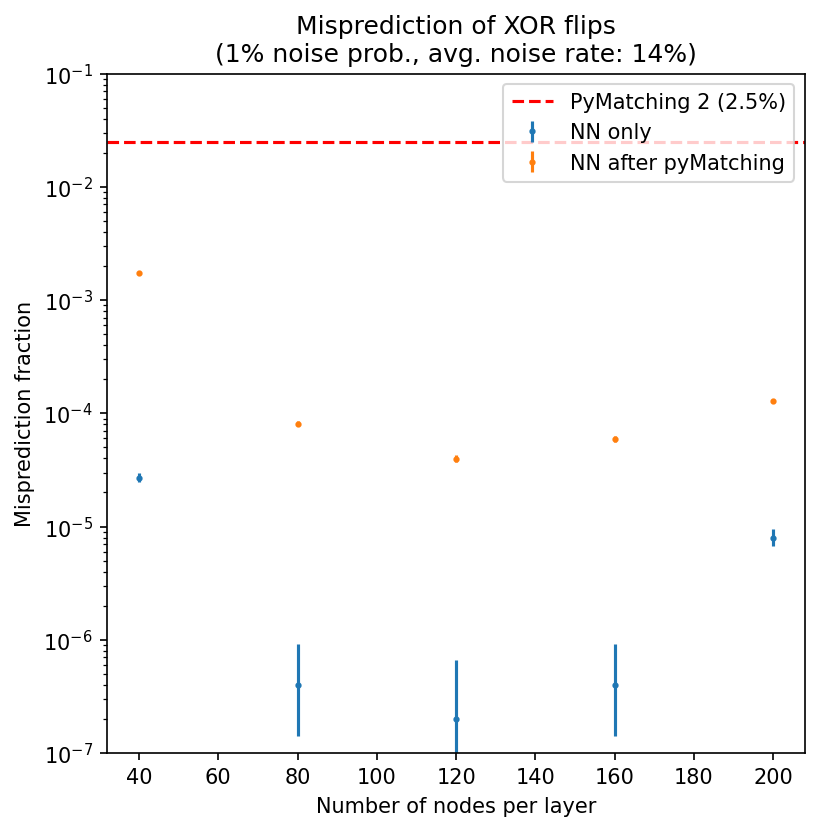

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True)

eff_wrong_XOR_nnonly_test = np.zeros(shape=(n_wrong_XOR_nnonly_test.shape[0],3), dtype=np.float32)
eff_wrong_XOR_wpym_test = np.zeros(shape=(n_wrong_XOR_wpym_test.shape[0],3), dtype=np.float32)
for iev in range(n_wrong_XOR_nnonly_test.shape[0]):
  eff_wrong_XOR_nnonly_test[iev][0] = np.float32(n_wrong_XOR_nnonly_test[iev]/feature_bits_test.shape[0])
  eff_wrong_XOR_wpym_test[iev][0] = np.float32(n_wrong_XOR_wpym_test[iev]/feature_bits_test_wpym.shape[0])
  eff_wrong_XOR_nnonly_test[iev][1], eff_wrong_XOR_nnonly_test[iev][2] = np.float32(efficiency_interval(n_wrong_XOR_nnonly_test[iev], feature_bits_test.shape[0]))
  eff_wrong_XOR_wpym_test[iev][1], eff_wrong_XOR_wpym_test[iev][2] = np.float32(efficiency_interval(n_wrong_XOR_wpym_test[iev], feature_bits_test_wpym.shape[0]))

incorrect_pym_rate = np.sum(incorrect_matches.reshape(-1,), dtype=np.float32)/incorrect_matches.shape[0]
avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]

ax.errorbar(
  x=nnodes,
  y=eff_wrong_XOR_nnonly_test[:,0],
  yerr=[
    eff_wrong_XOR_nnonly_test[:,0]-eff_wrong_XOR_nnonly_test[:,1],
    eff_wrong_XOR_nnonly_test[:,2]-eff_wrong_XOR_nnonly_test[:,0]
  ],
  fmt='o',
  label='NN only',
  markersize=2
)
ax.errorbar(
  x=nnodes,
  y=eff_wrong_XOR_wpym_test[:,0],
  yerr=[
    eff_wrong_XOR_wpym_test[:,0]-eff_wrong_XOR_wpym_test[:,1],
    eff_wrong_XOR_wpym_test[:,2]-eff_wrong_XOR_wpym_test[:,0]
  ],
  fmt='o',
  label='NN after pyMatching',
  markersize=2
)
ax.axhline(y=incorrect_pym_rate, color='r', linestyle='--', label=f'PyMatching 2 ({incorrect_pym_rate*100.:.1f}%)')
ax.set_xlabel('Number of nodes per layer')
ax.set_ylabel('Misprediction fraction')
ax.set_title(f'Misprediction of XOR flips\n(1% noise prob., avg. noise rate: {avg_flips*100.:.0f}%)')
ax.legend()
ax.set_ylim([1e-7, 1e-1])
ax.set_yscale('log')
fig.set_dpi(150)